# ENVIROMENT SETTING

In [1]:
# Octopus ML pakage - github.com/gershonc/octopus-ml
# !pip install pandas==1.2.0--upgrade
!pip install octopus-ml
!pip install catboost
!pip install bayesian-optimization
!pip install missingpy 
# !pip install -q -U git+https://github.com/mljar/mljar-supervised.git@master

In [2]:
# COLAB ONLY
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import octopus_ml as oc
import sklearn as sk

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD

from multiprocessing.pool import ThreadPool
from multiprocessing import Pool 
from scipy.stats import ks_2samp

from xgboost import XGBClassifier
from catboost import Pool, cv, CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier

import lightgbm as lgb
from bayes_opt import BayesianOptimization
import missingpy 
import warnings
warnings.filterwarnings("ignore")

#### Data loading

In [4]:
folder_path = '/content/drive/MyDrive/Data/colabs_data/WiDS' #Kaggle: ../input/widsdatathon2021/ #Local PC: '.'
# raw features
# pd.read_csv(folder_path + "/TrainingWiDS2021.csv")
# pd.read_csv(folder_path + "/UnlabeledWiDS2021.csv")
# derived features
# df_train = pd.read_csv(folder_path + "/Data/train.csv")
# df_test = pd.read_csv(folder_path + "/Data/test.csv")

# New transformed data
df_full = pd.read_csv(folder_path + "/WiDS2021/Wids2021_full_feature_v5.csv")

# RIÊNG BỘ DỮ LIỆU 20210222 CẦN ĐỔI LẠI TYPE CHO 64 CỘT BOOLEAN, REPLACE INF VỚI NAN
cols_boolean = df_full.select_dtypes(include= 'boolean').columns
df_full[cols_boolean] = df_full[cols_boolean].astype('int')
df_full.replace([np.inf, -np.inf], np.nan, inplace = True)

# SỬA LẠI CỘT apache_2_diagnosis
def _clean_apache_2_diagnosis(x):
  try:
    out = str(int(float(x)))
  except:
    out = x
  return out
df_full['apache_2_diagnosis'] = df_full['apache_2_diagnosis'].apply(_clean_apache_2_diagnosis )

In [5]:
df_full[['icu_id', 'hospital_id']] = df_full[['icu_id', 'hospital_id']].astype('object')

#### Feature classification
Phân loại các loại nhãn dữ liệu cần xử lý


In [6]:
# Data type 
col_target = 'diabetes_mellitus'
cols_id = ['encounter_id', 'Unnamed: 0', 'Unnamed: 0.1','knn_value_16', 'knn_value_512', 'knn_value_64' ]# , 'total_chronic', 'has_complicator', 'has_history', 'apache_hist'
cols_cat = [i for i in df_full.select_dtypes('object').columns if i not in cols_id + [col_target]]
cols_num = [i for i in df_full if i not in cols_cat + cols_id + [col_target] ]
cols_ft = cols_cat + cols_num

In [7]:
# ms_model = missingpy.MissForest()
# df_full[cols_num] = ms_model.fit_transform(df_full[cols_num])

In [8]:
df_train = df_full[df_full['diabetes_mellitus'].notnull()]
df_test = df_full[df_full['diabetes_mellitus'].isnull()]
print(df_train.shape)
print(df_test.shape)

(130157, 1393)
(10234, 1393)


In [9]:
print("train info: \n", df_train.info() )
print("test info: \n", df_test.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130157 entries, 0 to 130156
Columns: 1393 entries, Unnamed: 0 to knn_value_512
dtypes: float64(1072), int64(315), object(6)
memory usage: 1.4+ GB
train info: 
 None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10234 entries, 130157 to 140390
Columns: 1393 entries, Unnamed: 0 to knn_value_512
dtypes: float64(1072), int64(315), object(6)
memory usage: 108.8+ MB
test info: 
 None


In [ ]:
# df_full.to_csv(folder_path + "/WiDS2021/fts_v5_with_fill_missing_numeric_by_model.csv", index = False)

### Model 1: XGBoost

In [ ]:
p_cat = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
  ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -10000))
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
  ('predictor', XGBClassifier(n_estimators= 100, n_jobs= -1, max_depth = 5 ))
])

cv_auc = cross_val_score( pipe, df_train[cols_ft], df_train[col_target], 
                         cv = 5, scoring = 'roc_auc', verbose = 1, n_jobs = -1)
pipe.fit(df_train[cols_ft], df_train[col_target])

print(cv_auc)
print(np.mean(cv_auc))
# Run với raw data, không thêm feature
# [0.85000521 0.84067354 0.83726405 0.7301786  0.8296305 ]
# => AUC at CV: 0.8175503796337711
# => AUC at LB: 0.70188

# Run với bộ feature đã được thêm (đên 20210222)
# [1.         1.         0.99999981 1.         1.        ]
# AUC at CV: 0.9999999616917048
# => AUC at LB: 0.5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.2min finished


Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                       

[1.         1.         0.99999981 1.         1.        ]
0.9999999616917048


#### SUBMISSION for SKLEARN PIPELINE

In [ ]:
df_test['diabetes_mellitus'] = pipe.predict( df_test[cols_ft])
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/submission.csv', index = False)

### Model 2: OctopusML

In [ ]:
p_cat = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
  ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -10000))
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
])

X = df_train[cols_ft] # pd.DataFrame(data = pipe.fit_transform( df_train[cols_ft]), columns= cols_ft)
y = df_train[col_target]

# Turning model
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.007,
        'subsample': 1,
        'colsample_bytree': 0.25,
        'reg_alpha': 3,
        'reg_lambda': 1,
        'scale_pos_weight': 3,
        'n_estimators': 10000,
        'verbose': 1,
        'max_depth': -1,
        'seed':100, 
        'force_col_wise': True
}

# clf,arr_f1_weighted,arr_f1_macro,arr_f1_positive,prediction_folds,preds_folds,y_folds= oc.cv(
#     X, y,
#     0.5,16000,shuffle=True,params=params)
clf = oc.lgbm(X_train = X, y_train = y, X_test = X, y_test = y, num = 16000, params=params)


# Model với bộ dữ liệu gốc, 10k estimators
# => AUC at CV: 
# => AUC at LB: 0.86139

# Model với bộ dữ liệu mới, 1k estimators
# => AUC at CV: 
# => AUC at LB: 0.84526

# Model với bộ dữ liệu mới, 100k estimators
# => AUC at CV: 
# => AUC at LB: 

# Model với bộ dữ liệu 23/2 763fts, 10k estimators
# => AUC at CV: 
# => AUC at LB:      

# Model với bộ dữ liệu 23/2 1066fts, 10k estimators
# => AUC at CV:  
# => AUC at LB:      

AttributeError: ignored

In [ ]:
df_test['diabetes_mellitus'] = clf.predict(pipe.transform( df_test[cols_ft]))
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/octopus_submission3.csv', index = False)

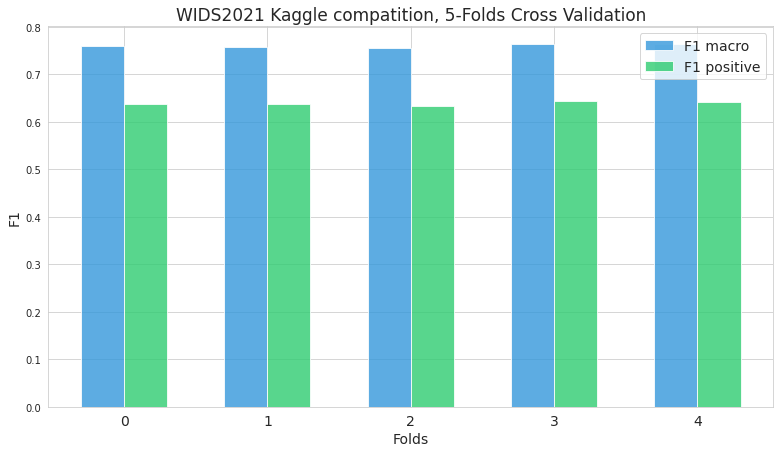

In [ ]:
# Model 2 
oc.cv_plot(arr_f1_weighted,arr_f1_macro,arr_f1_positive,'WIDS2021 Kaggle compatition')

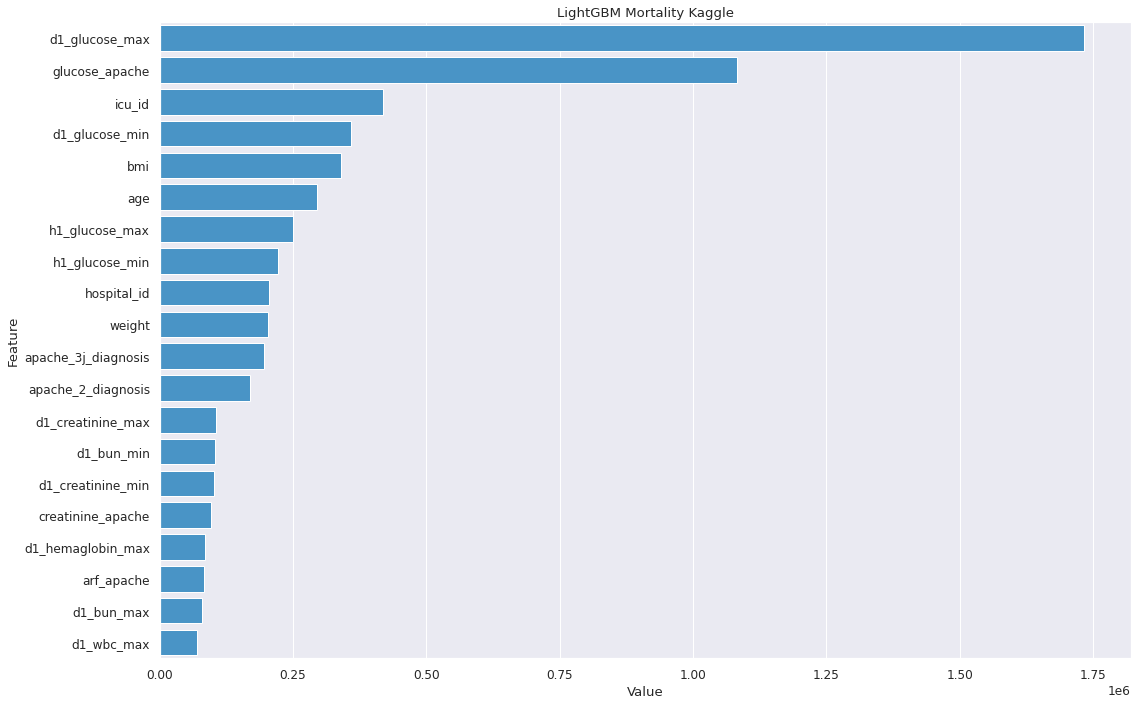

In [ ]:
# Model 2
feature_imp_list=oc.plot_imp(clf,X,'LightGBM Mortality Kaggle',num=20)

In [ ]:
df_train[cols_ft]

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_2_diagnosis,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,...,gluco_high_risk,age_glu_l,bmi_glu_l,age_glu_l_class,bmi_glu_l_class,age_bmi_glu_l,age_bmi_glu_l_class,age_bmi_glu_max_d,age_bmi_glu_max_h,creatinine_class,bun_class,glu_bun,glu_cre,glu_bun_class,glu_cre_class,glu_map_l,glu_map_l_class,age_weight,weight_glucose,bmi_glucose,age_glu_l_1,bmi_glu_l_1,age_glu_l_1_class,bmi_glu_l_1_class,age_bmi_glu_l_1,age_bmi_glu_l_1_class,age_bmi_glu_max_d_1,age_bmi_glu_max_h_1,bun_class_1,glu_bun_1,glu_cre_1,glu_bun_class_1,glu_cre_class_1,glu_map_l_1,glu_map_l_1_class,eyes_glu,glu_map,heart_glu,isolation_forest_score_1,isolation_forest_score_2
0,Caucasian,M,Floor,Floor,admit,CTICU,113,68.0,22.732803,0,180.3,92,0.541667,0,73.9,2.3,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,...,2,9.0,5.0,14.0,10.0,12.0,17.0,178.0,10.0,1,2,4,4,9,9,0.0,5.0,5025.2,12415.2,3819.110874,14.0,6.0,49.0,21.0,42.0,147.0,3528.0,0.0,1,4,2,14,7,-4.0,-14.0,504.0,14952.000000,19992.0,-0.382645,-0.429546
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,108,77.0,27.421875,0,160.0,90,0.927778,0,70.2,NaN,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.450,33.0,145.0,35.1,NaN,...,3,11.0,7.0,19.0,15.0,15.0,23.0,157.0,157.0,0,0,3,3,11,11,2.0,10.0,5405.4,10179.0,3976.171875,24.0,12.0,88.0,44.0,96.0,352.0,4640.0,4640.0,0,0,0,0,0,-3.0,-11.0,145.0,16868.333333,17110.0,-0.462446,-0.469581
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,122,25.0,31.952749,0,172.7,93,0.000694,0,95.3,NaN,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,36.7,NaN,...,0,2.0,5.0,2.0,5.0,7.0,7.0,7.0,7.0,0,0,0,0,0,0,0.0,0.0,2382.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.0,-0.358650,-0.364781
3,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU,203,81.0,22.635548,1,165.1,92,0.000694,0,61.7,NaN,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.390,4.0,NaN,34.8,NaN,...,2,10.0,5.0,14.0,9.0,13.0,17.0,196.0,11.0,0,0,2,2,6,6,0.0,4.0,4997.7,11414.5,4187.576423,16.0,6.0,48.0,18.0,48.0,144.0,4440.0,0.0,0,0,0,0,0,-4.0,-12.0,740.0,15663.333333,21460.0,-0.469663,-0.450534
4,Caucasian,M,outlier,Accident & Emergency,admit,Med-Surg ICU,119,19.0,NaN,0,188.0,91,0.073611,0,NaN,NaN,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,36.7,NaN,...,0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0,NaN,0.000000,0.0,-0.389875,-0.373997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,Caucasian,M,Emergency Department,Accident & Emergency,admit,Cardiac ICU,110,50.0,29.287256,0,175.3,1109,0.023611,0,90.0,NaN,104.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,106.0,NaN,0,120.0,NaN,NaN,NaN,NaN,50.0,NaN,36.2,1751.1552,...,0,5.0,4.0,5.0,4.0,9.0,9.0,9.0,9.0,0,0,0,0,0,0,2.0,2.0,4500.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.0,-0.385433,-0.416151
130153,Caucasian,F,Direct Admit,Accident & Emergency,admit,MICU,105,79.0,29.653433,0,162.6,1106,0.009722,0,78.4,3.5,207.01,0,0,0.7,3

### Model 3: Random forest

In [ ]:
p_cat = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value='missing')) ,
  ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -1000))
])
p1 = ColumnTransformer([
  # ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
  ('predictor', ensemble.RandomForestClassifier(n_estimators= 1000, n_jobs= -1))
])

cv_auc = cross_val_score( pipe, df_train[cols_ft], df_train[col_target], 
                         cv = 2, scoring = 'roc_auc', verbose = 1, n_jobs = -1)

print(cv_auc)
print(np.mean(cv_auc))
pipe.fit(df_train[cols_ft], df_train[col_target])
# Run với bộ feature đã được thêm (đên 20210222)
# => AUC at CV: [0.99959688 0.99941862 0.99965045 0.99966624 0.99953139] 0.9995727162353532
# => AUC at LB: 0.50331
# => bị data leakage => loại bỏ ft có importance quá cao




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 27.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 27.1min finished


[0.82859395 0.83748575]
0.8330398523367291


Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('fillna',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [ ]:
df_test['diabetes_mellitus'] = pipe.predict( df_test[cols_ft])
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/rf_20210223_1066ft_submission.csv', index = False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


                        ft_importance
weight_glucose               0.011229
bmi_glucose                  0.010328
d1_max_glucose_dis_0         0.009580
age_bmi_glu_max_d            0.008928
d1_max_glucose_dis_1         0.008909
glucose_max_mean_1           0.008836
glucose_d1_value_range       0.008658
eyes_glu                     0.008499
d1_glucose_max_t             0.008316
age_bmi_glu_max_d_1          0.008315
d1_glucose_max               0.008159
glucose_max_std_0            0.008134
glucose_max_mean_0           0.008013
glucose_max_std_1            0.007795
glucose_max_min              0.007721
glucose_max_min_d            0.007271
glucose_max                  0.007165
glucose_apache               0.006464
glucose_prob                 0.005084
glu_map                      0.005007
d_max_glu_class              0.004520
h1_glucose_min               0.004514
glu_cre                      0.004464
age_weight                   0.004381
bmi_glu_l                    0.004138
gluco_high_r

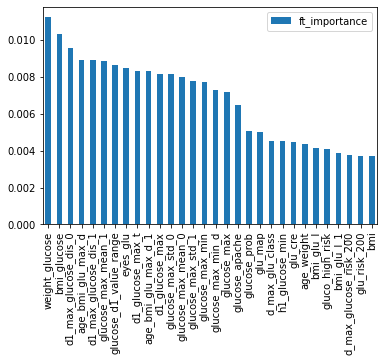

In [ ]:
ft_importance_df = pd.DataFrame.from_dict(dict(zip(cols_ft, pipe.named_steps['predictor'].feature_importances_)), orient='index', columns =['ft_importance'])
ft_importance_df.sort_values(by = 'ft_importance', ascending=False)[:30].plot(kind = 'bar')
print(ft_importance_df.sort_values(by = 'ft_importance', ascending=False)[:30])

### Model 4: ANN with tf feature column

In [ ]:
df_ft_full = pd.concat( [df_train[cols_ft], df_test[cols_ft]], axis = 0)
df_ft_full[cols_num] = df_ft_full[cols_num].fillna(df_ft_full[cols_num].mean())
df_ft_full[cols_cat] = df_ft_full[cols_cat].fillna('missing')
# df_ft_full = df_ft_full.reset_index(drop = True)
    
# df_ft_full[cols_cat] = df_ft_full[cols_cat].astype('object')
# df_ft_full[cols_num] = df_ft_full[cols_num].astype('float64')
df_train_full = pd.concat( [df_ft_full[:130157],df_train[[col_target]] ], axis = 1 )

# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=128):
    dataframe = dataframe.copy()
    try:
        labels = dataframe.pop(col_target)
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    except:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
                                                
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    
    # For performance turning
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

batch_size = 2048 # A small batch sized is used for demonstration purposes

df_to_train, df_to_val = train_test_split(df_train_full, test_size = 0.2, shuffle=True)

ds_train = df_to_dataset(df_to_train, batch_size=batch_size)
ds_val = df_to_dataset(df_to_val, shuffle=False, batch_size=batch_size)
ds_test = df_to_dataset(df_ft_full[130157:], shuffle=False, batch_size=batch_size)

# Check data is correct
for feature_batch, label_batch in ds_train.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['gender'])
    print('A batch of targets:', label_batch )

# FEATURE COLUMNS
fcs_num = [tf.feature_column.numeric_column(i) for i in cols_num]
fcs_cat = [
    tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            col, vocabulary_list = list(df_ft_full[col].drop_duplicates() )
        ), dimension = int(len(df_ft_full[col].drop_duplicates() ) * 0.15) +2
    )
    for col in cols_cat
]


Every feature: ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_diagnosis', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', '

In [ ]:

# MLP Nets
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(fcs_num ),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(1024, activation = 'relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(512, activation = 'relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(64, activation = 'relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.015), 
              metrics = [tf.keras.metrics.AUC()])
history = model.fit( ds_train, validation_data = ds_val,
                   epochs = 10, batch_size = 128)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
51/51 [==============================] - 30s 378ms/step - loss: 2534.6913 - auc: 0.4949
Epoch 2/10
51/51 [==============================] - 1s 20ms/step - loss: 1351.0450 - auc: 0.4975
Epoch 3/10
51/51 [==============================] - 1s 19ms/step - loss: 492.3982 - auc: 0.5449
Epoch 4/10
51/51 [==============================] - 1s 20ms/step - loss: 171.1960 - auc: 0.6113
Epoch 5/10
51/51 [==============================] - 1s 20ms/step - loss: 62.6805 - auc: 0.6354
Epoch 6/10
51/51 [==============================] - 1s 20ms/step - loss: 26.1346 - auc: 0.6348
Epoch 7/10
51/51 [==============================] - 1s 20ms/step - loss: 20.6199 - auc: 0.6264
Epoch 8/10
51/51 [==============================] - 1s 21ms/step - loss: 14.5392 - auc: 0.6268
Epoch 9/10
51/51 [==============================] - 1s 20ms/step - loss: 25.0115 - auc: 0.5928
Epoch 10/10
51/51 [========

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_10 (DenseFeat multiple                  0         
_________________________________________________________________
dense_40 (Dense)             multiple                  299       
Total params: 299
Trainable params: 299
Non-trainable params: 0
_________________________________________________________________


<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'AUC')

Text(0.5, 0, 'Epochs')

NameError: ignored

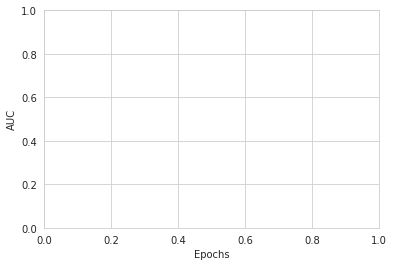

In [ ]:
# Exam results
plt.figure()
plt.ylabel("AUC")
plt.xlabel("Epochs")
# plt.ylim([0,2])
plt.plot(history.history['val_auc'],label='Validation')
plt.plot(history.history['auc'], label='Train')
plt.legend(loc='lower center', shadow=True, fontsize='medium')

### Model 5: Catboost

In [ ]:
p_cat = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
  # ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -10000))
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
])

# X = pd.DataFrame(data = pipe.fit_transform( df_train[cols_ft]), columns= cols_ft)
# y = df_train[col_target]
df_to_train, df_to_val = train_test_split(df_train, test_size = 0.2, shuffle=True)

X_train = pd.DataFrame(data = pipe.fit_transform( df_to_train[cols_ft]), columns= cols_ft)
y_train = df_to_train[col_target]

X_val = pd.DataFrame(data = pipe.transform( df_to_val[cols_ft]), columns= cols_ft)
y_val = df_to_val[col_target]

model = CatBoostClassifier(eval_metric='AUC', task_type="GPU", use_best_model=True, early_stopping_rounds=20)
    # verbose=True, task_type="GPU",depth=5, eval_metric="AUC",
    #                        iterations=1600,
    #                        learning_rate=0.06,
    #                        metric_period=4)
model.fit(X_train,y_train,
          cat_features= cols_cat,
          eval_set = (X_val, y_val), # ONLY IF use_best_model=True
          cat_features = cols_cat,
          plot=True,silent=True)
print(model.get_best_score())

# Sử dụng lại catboost với bộ ft 23/2; depth = 10
# => AUC at Train: 0.9560662508010864
# => AUC at LB: 0.69966

# Sử dụng lại catboost với bộ ft 23/2; depth = 5
# => AUC at Train: 0.8786202073097229
# => AUC at LB: 0.70308

# catboost ft 23/2, use_best_model = True
# => AUC at Train: 0.8755195736885071
# => AUC at Valid: 0.8592059910297394
# => AUC at LB: 0.69550

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'Logloss': 0.3496606767707083, 'AUC': 0.8744245171546936}, 'validation': {'Logloss': 0.3698656566317417, 'AUC': 0.8578012585639954}}


In [ ]:
df_test['diabetes_mellitus'] = model.predict(pipe.transform( df_test[cols_ft]))
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/catboost_submission.csv', index = False)

### Model 6: ANN with numpy

In [10]:
# NUMERIC ONLY: Xử lý missing và scaler dữ liệu
# pipe = Pipeline([
#   ('fillna', SimpleImputer(strategy='mean') ),
#   ('scaler', preprocessing.StandardScaler() )
# ])
# X_train = pipe.fit_transform(df_train[cols_num])
# X_test = pipe.transform(df_test[cols_num])
# y = df_train[col_target]

In [11]:
# FULL FEATURE: Xử lý missing và scaler dữ liệu
p_cat = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
  ('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])
p_num = Pipeline([
  ('scaler', preprocessing.StandardScaler() ),
  ('fillna', SimpleImputer(strategy='mean' )),
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
])

X_train = pipe.fit_transform(df_train[cols_ft])
X_test = pipe.transform(df_test[cols_ft])
y = df_train[col_target]

In [ ]:
# MLP Nets
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0015), 
              metrics = [tf.keras.metrics.AUC()])
history = model.fit( X_train, y, 
    epochs=50,batch_size=1024,
    validation_split = 0.3, 
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.3, 
            patience=3,
            epsilon = 1e-4, 
            mode = 'min',
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=10,
            mode='auto',
            verbose=1,
            baseline=None,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
89/89 [==============================] - 34s 369ms/step - loss: 0.6193 - auc_1: 0.7677 - val_loss: 0.4771 - val_auc_1: 0.8219
Epoch 2/50
89/89 [==============================] - 32s 360ms/step - loss: 0.4402 - auc_1: 0.8379 - val_loss: 0.4014 - val_auc_1: 0.8344
Epoch 3/50
89/89 [==============================] - 32s 362ms/step - loss: 0.3883 - auc_1: 0.8580 - val_loss: 0.3815 - val_auc_1: 0.8382
Epoch 4/50
89/89 [==============================] - ETA: 0s - loss: 0.3655 - auc_1: 0.8712

### Model 7: LightGBM with bayer_opt

In [ ]:
# p_cat = Pipeline([
#   ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
#   ('encode', preprocessing.OrdinalEncoder())
# ])
# p_num = Pipeline([
#   ('fillna', SimpleImputer(strategy='constant', fill_value= -1000))
# ])
# p1 = ColumnTransformer([
#   ('cat', p_cat, cols_cat),
#   ('num', p_num, cols_num)
# ])

# pipe = Pipeline([
#   ('transformer', p1),
# ])

# X = df_train[cols_num].fillna( df_train[cols_num].mean() ) #pd.DataFrame(data = pipe.fit_transform( df_train[cols_ft]), columns= cols_ft)
# y = df_train[col_target]
# train_data = lgb.Dataset(X, y)

# params = {
#         'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'metric': 'auc',
#         'learning_rate': 0.007,
#         'subsample': 1,
#         'colsample_bytree': 0.25,
#         'reg_alpha': 3,
#         'reg_lambda': 1,
#         'scale_pos_weight': 3,
#         'n_estimators': 10000,
#         'verbose': 1,
#         'max_depth': -1,
#         'seed':100, 
#         'force_col_wise': True
# }

In [ ]:

X = df_train[cols_num].fillna( df_train[cols_num].mean() )
y = df_train[col_target]
train_data = lgb.Dataset(X, y)

In [ ]:

def bayes_parameter_opt_lgb(init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, lambda_l1,learning_rate, lambda_l2, min_split_gain, min_child_weight,scale_pos_weight ):
        params = {'application':'binary', 'early_stopping_round':400, 'metric':'auc', 'max_depth':-1, 'force_col_wise': True, 'num_iterations': 10000}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        # params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['learning_rate'] = max(learning_rate, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['scale_pos_weight'] = scale_pos_weight
        # params['num_iterations'] = int(round(num_iterations))
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =2000, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            # 'max_depth': (-1, 9.99),
                                            'lambda_l1': (0, 10),
                                            'learning_rate' :(0.001, 0.1),
                                            'lambda_l2': (0, 7),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50),
                                            'scale_pos_weight': (0.25,5),
                                            # 'num_iterations' : (5000, 30000),
                                            }
                                 , random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO#.res['max']['max_params']

opt_params = bayes_parameter_opt_lgb(init_round=5, opt_round=15, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | min_ch... | min_sp... | num_le... | scale_... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8736   |  0.7744   |  0.6722   |  6.028    |  3.814    |  0.04294  |  34.07    |  0.04432  |  42.73    |  4.827    |
|  2        |  0.8716   |  0.6917   |  0.7334   |  5.289    |  3.976    |  0.09263  |  8.197    |  0.009626 |  24.42    |  4.205    |
|  3        |  0.8738   |  0.8891   |  0.796    |  9.786    |  5.594    |  0.04669  |  40.12    |  0.01271  |  37.44    |  0.9309   |
|  4        |  0.8728   |  0.9723   |  0.5175   |  4.147    |  1.852    |  0.07765  |  25.53    |  0.05727  |  24.39    |  3.184    |
|  5        |  0.8741   |  0.806    |  0.5935   |  9.437    |  4.773    |  0.03659  |  24.67    |  0.07007  |  25.26    |  3.417    |
[2000]	cv_agg's auc: 0.875444 + 0.00177846


In [ ]:
opt_params.max['params']

{'bagging_fraction': 0.9378575435397469,
 'feature_fraction': 0.21278540965196477,
 'lambda_l1': 9.792620949849862,
 'lambda_l2': 4.145628767451438,
 'learning_rate': 0.011037646711803246,
 'min_child_weight': 5.257280958445634,
 'min_split_gain': 0.03359751016648394,
 'num_iterations': 23235.991908367396,
 'num_leaves': 43.14869795093739,
 'scale_pos_weight': 4.536932941176303}

In [ ]:
# Tham số tối ưu khi chạy lần 1
{'bagging_fraction': 0.8627610456801741,
 'feature_fraction': 0.22867949285484263,
 'lambda_l1': 4.915093577588832,
 'lambda_l2': 2.1844578563836654,
 'learning_rate': 0.05948122014417289,
 'max_depth': 8.365454090949921,
 'min_child_weight': 5.476407656454099,
 'min_split_gain': 0.0934080616100052,
 'num_leaves': 44.19727955721166}
 # Tham số tối ưu sau khi chạy lần 2
{'bagging_fraction': 0.9008399046365135,
 'feature_fraction': 0.7748604915950269,
 'lambda_l1': 1.35117024942996,
 'lambda_l2': 0.18714470520589788,
 'learning_rate': 0.019366725725186988,
 'max_depth': 8.80615503858714,
 'min_child_weight': 41.44208988221294,
 'min_split_gain': 0.04529307316405565,
 'num_leaves': 44.53568494061379}

 # Tham số tối ưu sau khi chạy lần 3| Best AUC at CV = 0.8918419001512705
 {'bagging_fraction': 0.8766805307530916,
 'feature_fraction': 0.8642027679654405,
 'lambda_l1': 4.912602026444597,
 'lambda_l2': 2.437499183488889,
 'learning_rate': 0.02501159905983583,
 'min_child_weight': 10.077249918461563,
 'min_split_gain': 0.05624653693483012,
 'num_leaves': 32.35902690851246,
 'scale_pos_weight': 0.7903383094151535}

{'bagging_fraction': 0.8627610456801741,
 'feature_fraction': 0.22867949285484263,
 'lambda_l1': 4.915093577588832,
 'lambda_l2': 2.1844578563836654,
 'learning_rate': 0.05948122014417289,
 'max_depth': 8.365454090949921,
 'min_child_weight': 5.476407656454099,
 'min_split_gain': 0.0934080616100052,
 'num_leaves': 44.19727955721166}

{'bagging_fraction': 0.9008399046365135,
 'feature_fraction': 0.7748604915950269,
 'lambda_l1': 1.35117024942996,
 'lambda_l2': 0.18714470520589788,
 'learning_rate': 0.019366725725186988,
 'max_depth': 8.80615503858714,
 'min_child_weight': 41.44208988221294,
 'min_split_gain': 0.04529307316405565,
 'num_leaves': 44.53568494061379}

In [ ]:
ms_inputer = missingpy.MissForest()

In [ ]:
# Train only with best params | 20210225
best_params =  {'bagging_fraction': 0.8766805307530916,
 'feature_fraction': 0.8642027679654405,
 'lambda_l1': 4.912602026444597,
 'lambda_l2': 2.437499183488889,
 'learning_rate': 0.02501159905983583,
 'min_child_weight': 10.077249918461563,
 'min_split_gain': 0.05624653693483012,
 'num_leaves': 32.35902690851246,
 'scale_pos_weight': 0.7903383094151535}
def lgb_params( params ):
    params2 = {'application':'binary', 'early_stopping_round':400, 'metric':'auc', 'max_depth':-1, 'force_col_wise': True}
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['learning_rate'] = max(learning_rate, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params['scale_pos_weight'] = scale_pos_weight
    params['num_iterations'] = int(round(num_iterations))
    return dict( params, **params2)


In [ ]:
# Without categorical columns| 20210225
best_params =  {'bagging_fraction': 0.8766805307530916,
  'feature_fraction': 0.8642027679654405,
  'lambda_l1': 4.912602026444597,
  'lambda_l2': 2.437499183488889,
  'learning_rate': 0.02501159905983583,
  'min_child_weight': 10.077249918461563,
  'min_split_gain': 0.05624653693483012,
  'num_leaves': 32.35902690851246,
  'scale_pos_weight': 0.7903383094151535}
  
def lgb_params( params ):
    params2 = {'application':'binary', 'early_stopping_round':400, 'metric':'auc', 'max_depth':-1, 'force_col_wise': True}
    params['feature_fraction'] = max(min(params['feature_fraction'], 1), 0)
    params['bagging_fraction'] = max(min(params['bagging_fraction'], 1), 0)
    params['num_leaves'] = int(round(params['num_leaves']))
    params['lambda_l1'] = max(params['lambda_l1'], 0)
    params['learning_rate'] = max(params['learning_rate'], 0)
    params['lambda_l2'] = max(params['lambda_l2'], 0)
    return dict( params, **params2)

X = df_train[cols_num].fillna( df_train[cols_num].mean() )
y = df_train[col_target]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
to_train_data = lgb.Dataset(X_train, y_train)
to_val_data = lgb.Dataset(X_test, y_test)

model = lgb.train( lgb_params(best_params) , to_train_data, verbose_eval =200, valid_sets = to_val_data)

Training until validation scores don't improve for 400 rounds.
[200]	valid_0's auc: 0.861223
[400]	valid_0's auc: 0.869433
[600]	valid_0's auc: 0.871435
[800]	valid_0's auc: 0.872315
[1000]	valid_0's auc: 0.872818
[1200]	valid_0's auc: 0.873001
[1400]	valid_0's auc: 0.8732
[1600]	valid_0's auc: 0.873342
[1800]	valid_0's auc: 0.87332
Early stopping, best iteration is:
[1579]	valid_0's auc: 0.873358


In [ ]:
# training với bộ paras cũ của octopus ML
best_params =  {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.007,
        'subsample': 1,
        'colsample_bytree': 0.25,
        'reg_alpha': 3,
        'reg_lambda': 1,
        'scale_pos_weight': 3,
        'n_estimators': 10000,
        'verbose': 1,
        'max_depth': -1,
        'seed':100, 
        'force_col_wise': True
}

X = df_train[cols_num].fillna( df_train[cols_num].mean() )
y = df_train[col_target]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=90)
to_train_data = lgb.Dataset(X_train, y_train)
to_val_data = lgb.Dataset(X_test, y_test)

model = lgb.train( best_params , to_train_data, verbose_eval =200, valid_sets = to_val_data)

[200]	valid_0's auc: 0.843169
[400]	valid_0's auc: 0.852794
[600]	valid_0's auc: 0.859517
[800]	valid_0's auc: 0.864549
[1000]	valid_0's auc: 0.867704
[1200]	valid_0's auc: 0.86976
[1400]	valid_0's auc: 0.870971
[1600]	valid_0's auc: 0.871759
[1800]	valid_0's auc: 0.872315
[2000]	valid_0's auc: 0.872719
[2200]	valid_0's auc: 0.873028
[2400]	valid_0's auc: 0.87325
[2600]	valid_0's auc: 0.873493
[2800]	valid_0's auc: 0.873649
[3000]	valid_0's auc: 0.8738
[3200]	valid_0's auc: 0.873938
[3400]	valid_0's auc: 0.874032
[3600]	valid_0's auc: 0.874136
[3800]	valid_0's auc: 0.874191
[4000]	valid_0's auc: 0.874233
[4200]	valid_0's auc: 0.874268
[4400]	valid_0's auc: 0.874333
[4600]	valid_0's auc: 0.874375
[4800]	valid_0's auc: 0.874397
[5000]	valid_0's auc: 0.874473
[5200]	valid_0's auc: 0.874531
[5400]	valid_0's auc: 0.874573
[5600]	valid_0's auc: 0.874595
[5800]	valid_0's auc: 0.874633
[6000]	valid_0's auc: 0.874673
[6200]	valid_0's auc: 0.874663
[6400]	valid_0's auc: 0.874671
[6600]	valid_0's

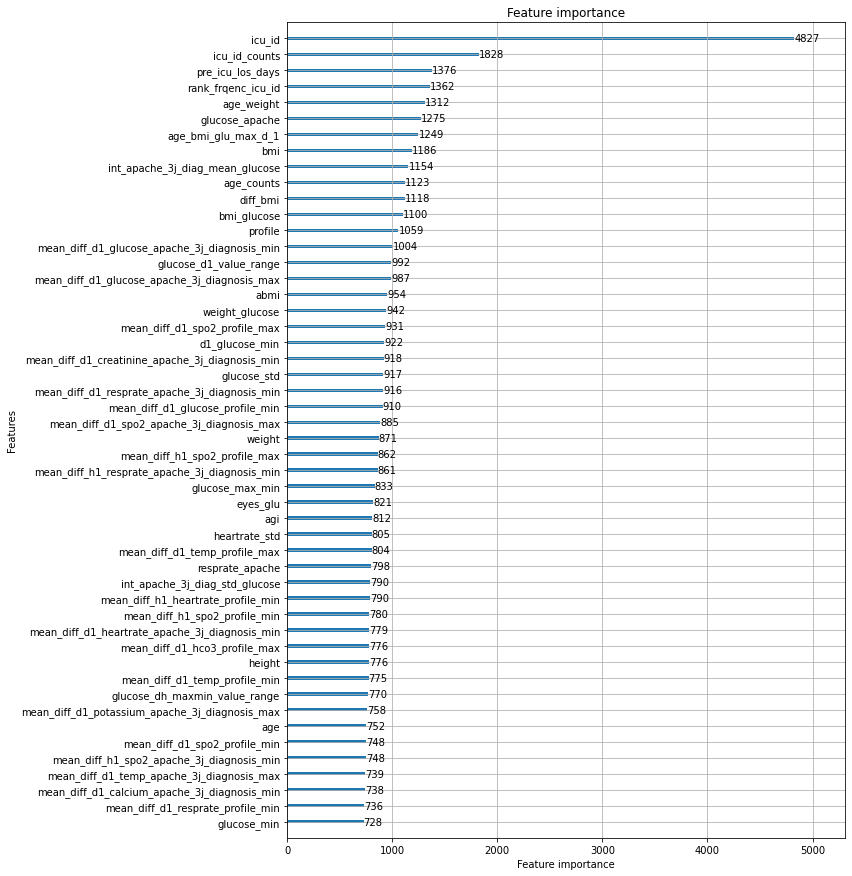

In [ ]:
lgb.plot_importance(model, max_num_features  = 50,figsize  = (10,15))

In [ ]:
# With categorical columns
best_params = opt_params.max['params']
def lgb_params( params ):
    params2 = {'application':'binary','num_iterations': 10000, 'early_stopping_round':100, 'metric':'auc'} 
    params['feature_fraction'] = max(min(params['feature_fraction'], 1), 0)
    params['bagging_fraction'] = max(min(params['bagging_fraction'], 1), 0)
    params['num_leaves'] = int(round(params['num_leaves']))
    params['max_depth'] = int(round(params['max_depth']))
    params['lambda_l1'] = max(params['lambda_l1'], 0)
    params['learning_rate'] = max(params['learning_rate'], 0)
    params['lambda_l2'] = max(params['lambda_l2'], 0)
    return dict( params, **params2)

X = pd.concat(
      [df_train[cols_num].fillna( df_train[cols_num].mean() ) , 
       df_train[cols_cat].fillna('MISSING')], axis =1 )
y = df_train[col_target]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
to_train_data = lgb.Dataset(X_train, y_train, categorical_feature= cols_cat)
to_val_data = lgb.Dataset(X_test, y_test, categorical_feature= cols_cat)

model = lgb.train( lgb_params(best_params) , to_train_data, verbose_eval =200, valid_sets = to_val_data)

In [ ]:
# Predict and submission
X_test = df_test[cols_num].fillna( df_train[cols_num].mean() ) 
df_test[col_target] = model.predict(X_test)
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/lgbm_submission_data_v5_octopus_params_removeKnnCol.csv', index = False)

# SUBMISSION

In [ ]:
df_test['diabetes_mellitus'] = clf.predict(pipe.transform( df_test[cols_ft]))
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/submission.csv', index = False)

## CHECK ERROR

In [ ]:
for i in cols_cat:
  test_and_not_train = [t for t in df_test[i].unique() if t not in df_train[i].unique()]
  if len(test_and_not_train) !=0:
    print('column with value in test data but not train: ', i, ' ; \n value: ', test_and_not_train)
  train_and_not_test = [t for t in df_train[i].unique() if t not in df_test[i].unique()]
  if len(train_and_not_test) != 0:
    print('column with value in train data but not test: ', i, ' ; \n value: ', train_and_not_test)


column with value in test data but not train:  ethnicity  ; 
 value:  [nan]
column with value in train data but not test:  ethnicity  ; 
 value:  [nan]
column with value in test data but not train:  gender  ; 
 value:  [nan]
column with value in train data but not test:  gender  ; 
 value:  [nan]
column with value in test data but not train:  hospital_admit_source  ; 
 value:  [nan]
column with value in train data but not test:  hospital_admit_source  ; 
 value:  [nan, 'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other']
column with value in test data but not train:  icu_admit_source  ; 
 value:  [nan]
column with value in train data but not test:  icu_admit_source  ; 
 value:  [nan]


In [ ]:
# hospital_admit_source  
print(df_train['hospital_admit_source'].unique())
print(df_test['hospital_admit_source'].unique())

['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']
['Floor' 'Emergency Department' 'Direct Admit' nan 'Operating Room'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Step-Down Unit (SDU)' 'Chest Pain Center']


In [ ]:
df_train[i].unique()

array(['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU',
       'Cardiac ICU', 'CSICU'], dtype=object)

In [ ]:
'CTICU' not in df_test[i].unique()

False

In [ ]:
# # Kiểm tra vì sao pipe bị lỗi
# pipe[0].transformers[0][1].fit(df_train[cols_cat])
# pipe[0].transformers[0][1].transform(df_test[cols_cat])
# # =>cat pipe work well
# pipe[0].transformers[1][1].fit(df_train[cols_num])
# pipe[0].transformers[1][1].transform(df_test[cols_num])
# # =>num pipe work well

# pipe[0].fit(df_train[cols_ft])
# pipe[0].transform(df_test[cols_ft])
# # # => all pipe work well

array([[ 2.,  0.,  4., ...,  0.,  0.,  0.],
       [ 2.,  0.,  3., ...,  0.,  0.,  0.],
       [ 2.,  0.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 2.,  0., 14., ...,  0.,  0.,  0.],
       [ 2.,  0.,  3., ...,  0.,  0.,  0.],
       [ 2.,  1.,  3., ...,  0.,  0.,  0.]])

In [ ]:
pipe.predict(df_test[cols_ft])

XGBoostError: ignored

# LOG

In [ ]:
'''
20210221
Model1: Run với raw data, không thêm feature => XGboost đơn giản
[0.85000521 0.84067354 0.83726405 0.7301786  0.8296305 ]
=> AUC at CV: 0.8175503796337711
=> AUC at LB: 0.70188

Model với bộ dữ liệu gốc, không thêm features, 10k estimators, train với octopus ML 
training rất lâu nhưng hiệu quả là tốt
=> AUC at CV: 
=> AUC at LB: 0.86139

20210222

'''